In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
heart_failure <- read_csv("data/heart_failure_clinical_records_dataset.csv")
heart_failure

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


In [3]:
heart_data <- heart_failure |>
    select(age, creatinine_phosphokinase, ejection_fraction,serum_creatinine, serum_sodium, sex, smoking, platelets, DEATH_EVENT) 
    
heart_data

age,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,sex,smoking,platelets,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,582,20,1.9,130,1,0,265000,1
55,7861,38,1.1,136,1,0,263358,1
65,146,20,1.3,129,1,1,162000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,2060,60,0.8,138,0,0,742000,0
45,2413,38,1.4,140,1,1,140000,0
50,196,45,1.6,136,1,1,395000,0


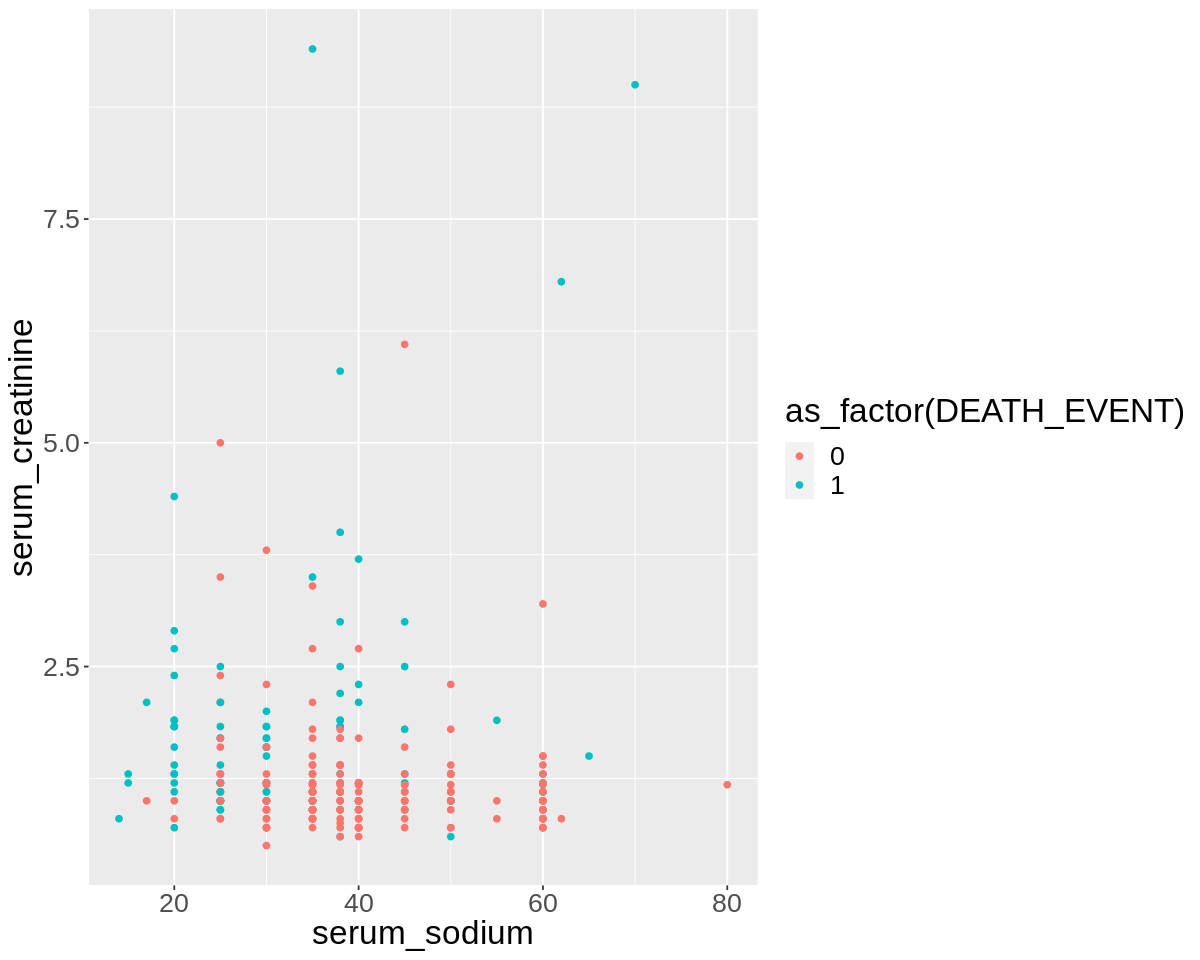

In [12]:
options(repr.plot.height = 8, repr.plot.width = 10)
plot_age_4 <- heart_data |>
    ggplot(aes(x = ejection_fraction, y = serum_creatinine, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "serum_sodium", y = "serum_creatinine")+
        theme(text = element_text(size = 20)) 
        
plot_age_4

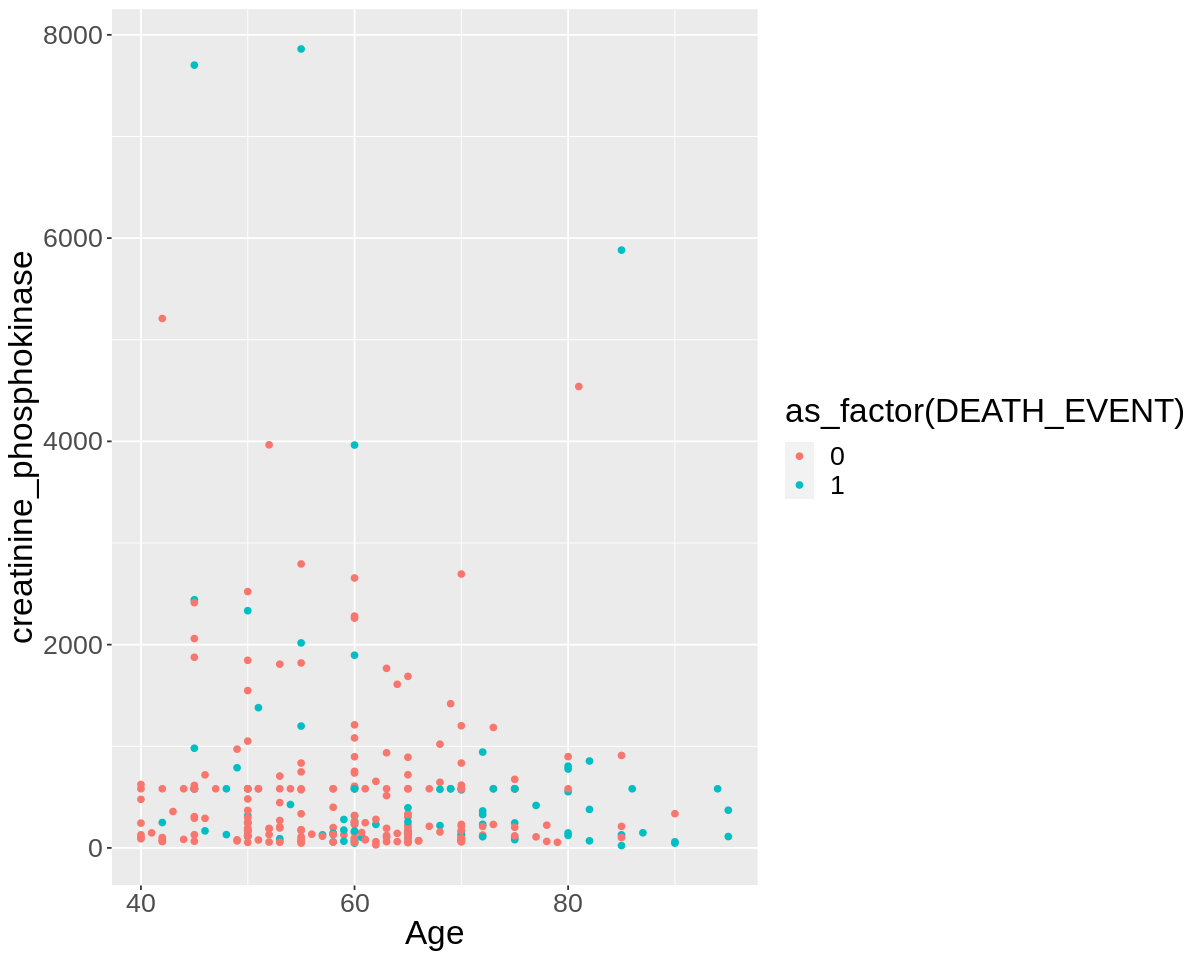

In [13]:
plot_age_1 <- heart_data |>
    ggplot(aes(x = age, y = creatinine_phosphokinase, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "Age", y = "creatinine_phosphokinase")+
        theme(text = element_text(size = 20)) 
        
plot_age_1

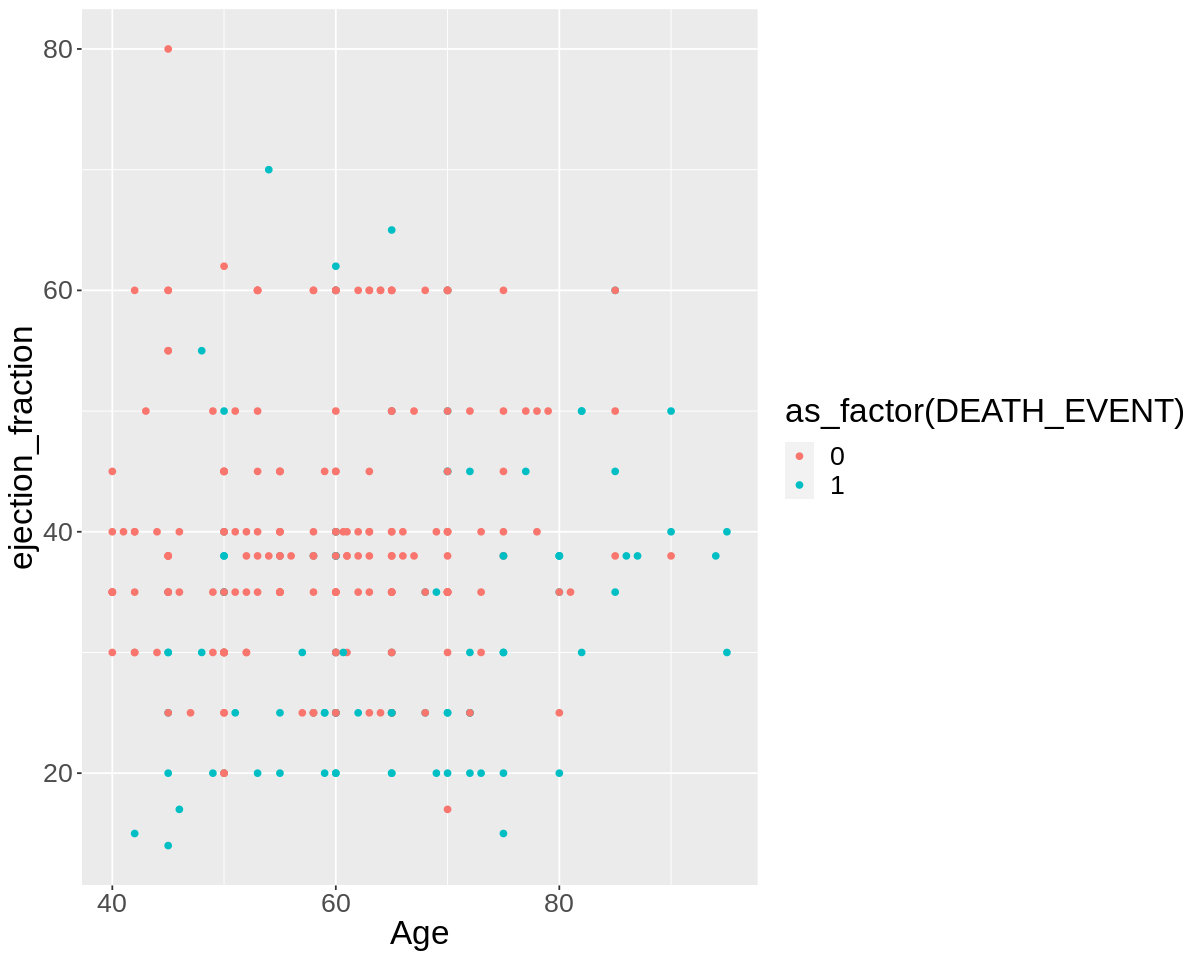

In [14]:
plot_age_2 <- heart_data |>
    ggplot(aes(x = age, y = ejection_fraction, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "Age", y = "ejection_fraction")+
        theme(text = element_text(size = 20)) 
        
plot_age_2

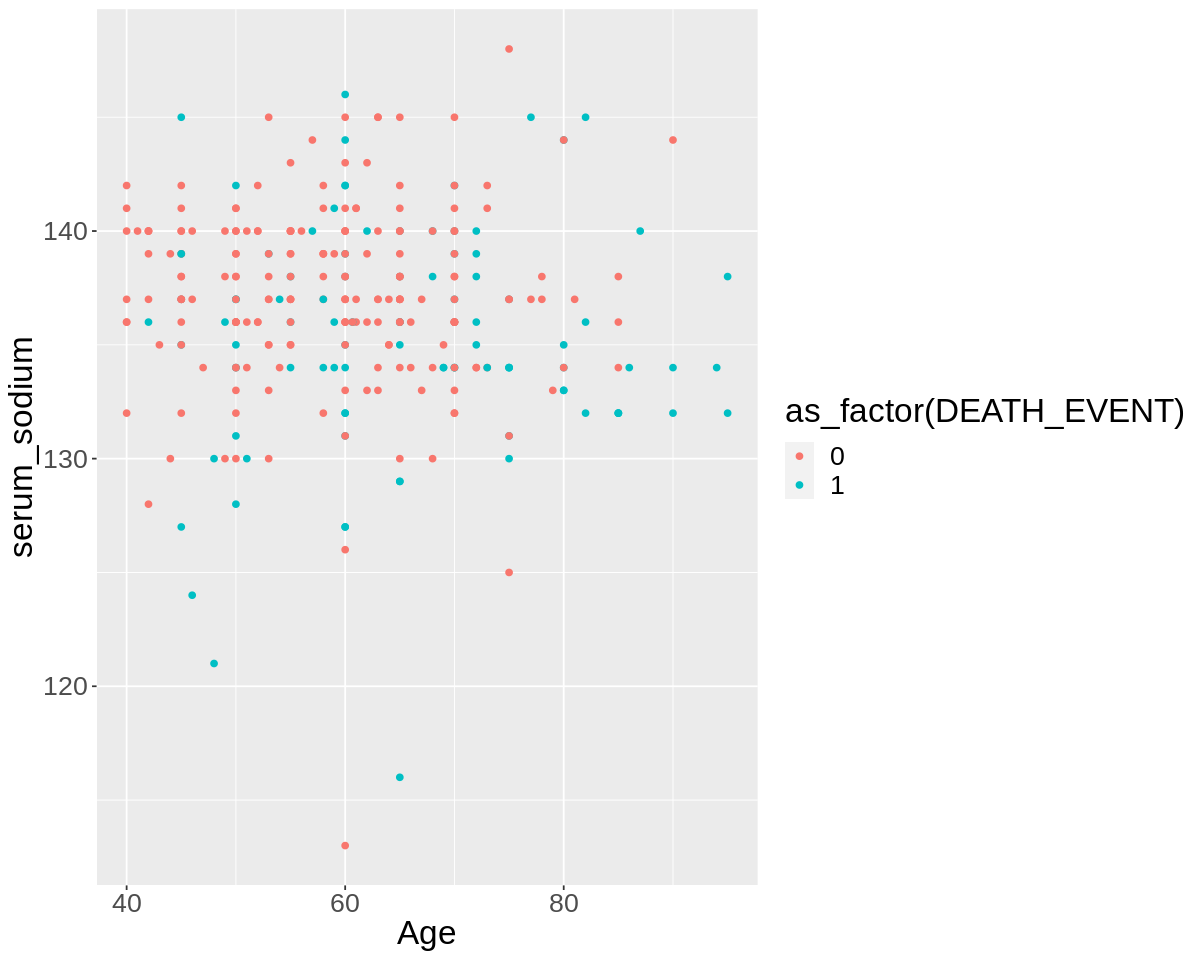

In [15]:
plot_age_3 <- heart_data |>
    ggplot(aes(x = age, y = serum_sodium, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "Age", y = "serum_sodium")+
        theme(text = element_text(size = 20)) 
        
plot_age_3

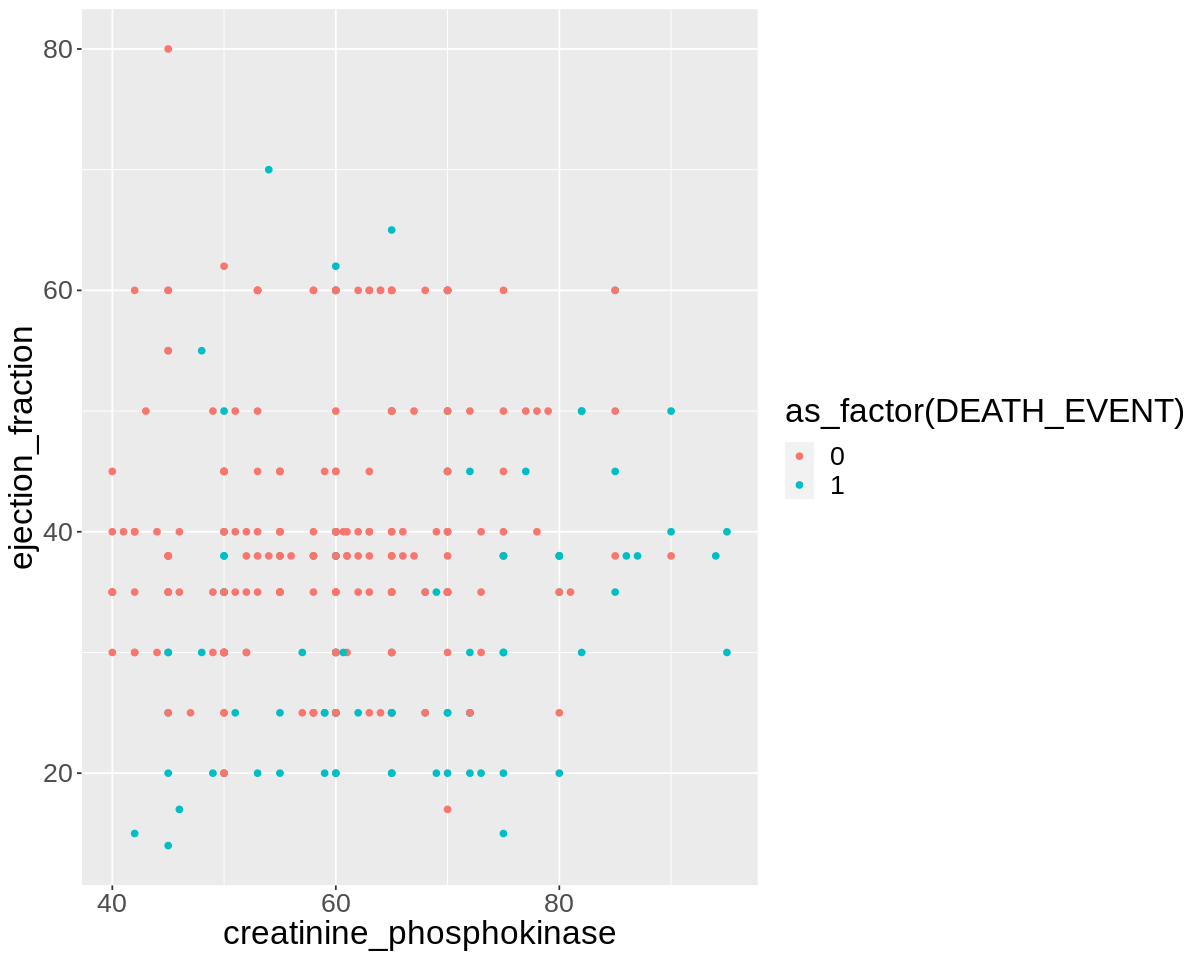

In [16]:
plot_creatinine_1 <- heart_data |>
    ggplot(aes(x = age, y = ejection_fraction, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "creatinine_phosphokinase", y = "ejection_fraction") +
        theme(text = element_text(size = 20))
    
plot_creatinine_1

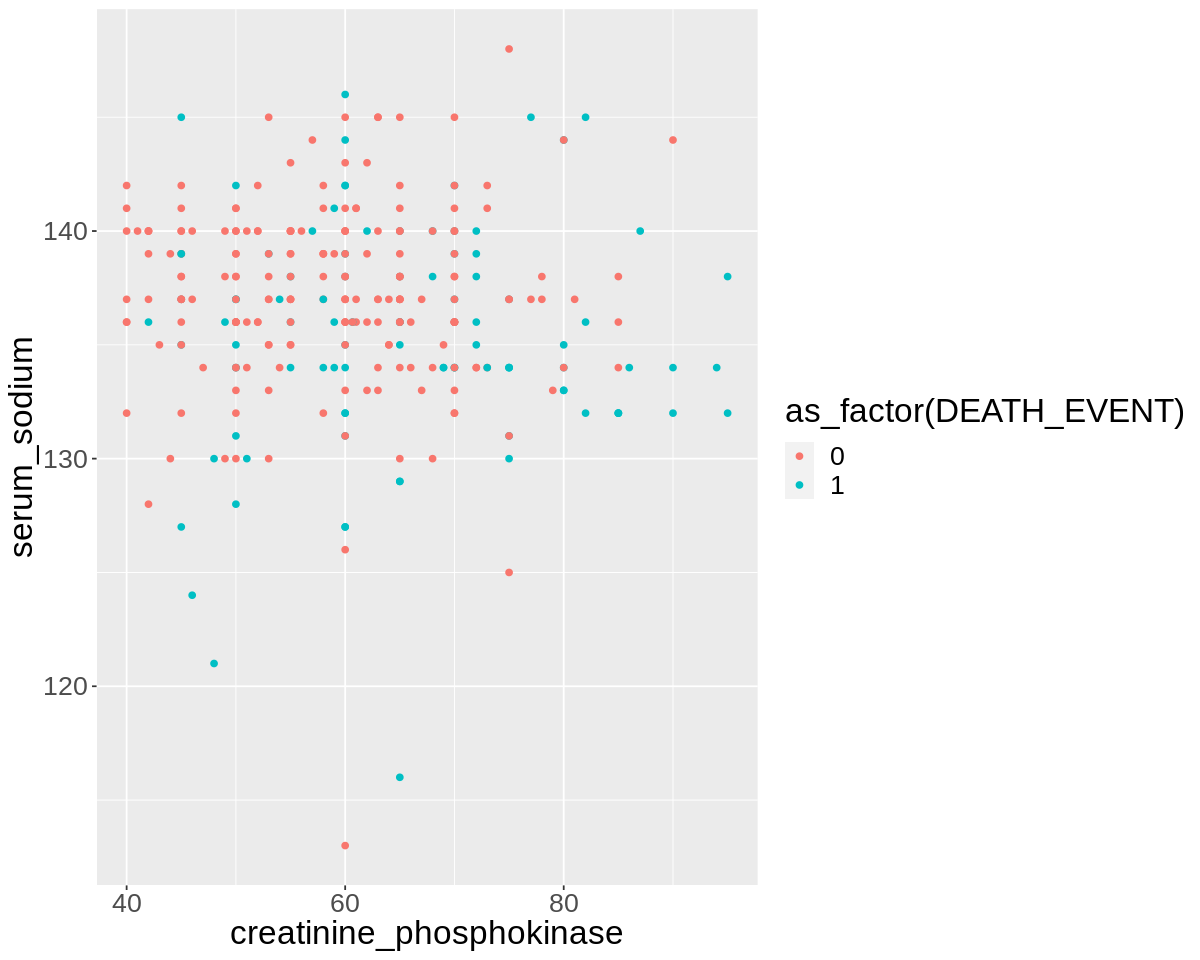

In [17]:
plot_creatinine_2 <- heart_data |>
    ggplot(aes(x = age, y = serum_sodium, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "creatinine_phosphokinase", y = "serum_sodium") +
        theme(text = element_text(size = 20))
    
plot_creatinine_2

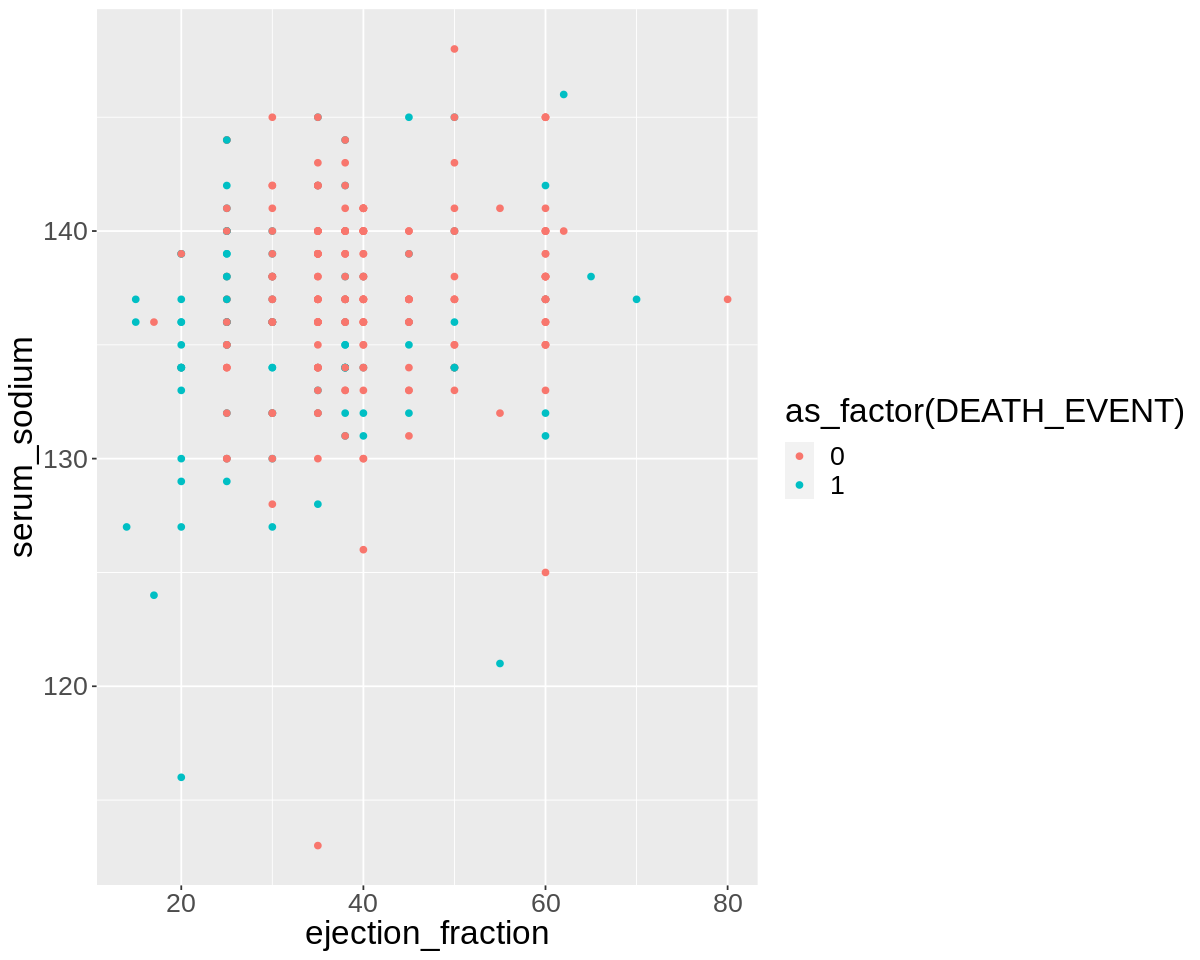

In [18]:
options(repr.plot.height = 8, repr.plot.width = 10)
plot_ejection_fraction <- heart_data |>
    ggplot(aes(x = ejection_fraction, y = serum_sodium, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "ejection_fraction", y = "serum_sodium") +
        theme(text = element_text(size = 20))
    
plot_ejection_fraction